# Crazy Raisins: A Raisin Classification Adventure

Authors: Yasaman Baher, Shreya Kakachery, Eric Wong 

## Summary
A simple classification analysis of two raisin varieties, Kecimen and Besni, based on data derived from images.

## Introduction
Raisins are dried grapes although other small berries and fruit may be dried using the same methodology of raisins. Just like their undried form, raisins of different varieties may differ in taste, chewiness, sweetness, etc. They provide a variety of health benefits which include: "... a better diet quality and may reduce appetite."(Olmo-Cunillera et al. 1) The analysis below will attempt to predict which variety of raisins are based on data derived from multiple images taken of 900 samples. The dataset is obtained from the UCI database archive and contains numeric features all indicating the properties of the sampled raisin. If our model can accurately predict the species of raisins given it's measured properties, we can avoid eating raisins that are not to our preference.

In [34]:
from ucimlrepo import fetch_ucirepo
import altair as alt
import pandas as pd
from hashlib import sha1
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


raisin = fetch_ucirepo(id=850)

In [35]:
X = raisin.data.features     # the features (7 morphological measurements)  
y = raisin.data.targets      # the class labels (Kecimen vs Besni) 

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.3 KB


*Fig. 1 High-level information about the features where all are numerical and have no NULL values*

In [37]:
X.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


*Fig. 2 Statistical overview of the numerical features to determine if any preprocessing is required. Initial thoughts are to use StandardScaler()*

In [38]:
# Check for duplicate observations in the dataset
duplicates = X.duplicated().sum()
if duplicates > 0:
    raise ValueError(f"Dataset contains {duplicates} duplicate observations.")
else:
    print("No duplicate observations found in the dataset.")

No duplicate observations found in the dataset.


In [39]:
# Check if data is within reasonable ranges
columns_to_check = {'Area': (25380, 235050),
    'MajorAxisLength': (223, 1000),
    'MinorAxisLength': (140, 495),
    'Eccentricity': (0.348, 0.9622),
    'ConvexArea': (26138, 278218),
    'Extent': (0.379, 0.836),
    'Perimeter': (619, 2698)}
for column, (min_val, max_val) in columns_to_check.items():
    if not X[column].between(min_val, max_val).all():
        raise ValueError(f"Values in column '{column}' are out of expected range.")

In [40]:
df = pd.concat([X, y], axis=1)
df["Class"] = df["Class"].astype(str)

axis_length_scatterplot = alt.Chart(df).mark_circle(size=60).encode(
    x='MajorAxisLength:Q',
    y='MinorAxisLength:Q',
    color='Class:N',
    tooltip=['Class', 'Area', 'Perimeter']
).properties(title = 'Minor Axis vs. Major Axis Length')

axis_length_scatterplot

alt.Chart(...)

*Fig. 3 Plotting the two major measurements as a scatterplot to see the distribution of both varieties of raisins*

In [41]:
correlation_matrix = X.corr().stack().reset_index()
correlation_matrix.columns = ['Feature1', 'Feature2', 'Correlation']
correlation_heatmap = alt.Chart(correlation_matrix).mark_rect().encode(
    x='Feature1:N',
    y='Feature2:N',
    color=alt.Color('Correlation:Q', scale=alt.Scale(range='diverging'), title='Correlation')
).properties(
    width=400,
    height=400
)
annotations = alt.Chart(correlation_matrix).mark_text(baseline='middle').encode(
    x='Feature1:N',
    y='Feature2:N',
    text=alt.Text('Correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.Correlation > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)
correlation_heatmap = correlation_heatmap + annotations
correlation_heatmap

alt.LayerChart(...)

*Fig. 4 Pearson correlation matrix of each numerical feature*

# Methods
## Data
The dataset used in this project is the digitized raisin images by İ̇lkay Çinar, Murat Koklu, and Sakir Tasdemir from Selcuck University. The data can be obtained from [[here](https://archive.ics.uci.edu/dataset/850/raisin)] and was imported through the ucimlrepo python library. Each row represents a measurement of a raisin belonging to either the Besni or Kecimen variety.

## Analysis
The LogisticRegression algorithm was used to build the classification model to predict the species of a raisin given its measured shape properties. The data was split 75% and 25% to the training and test datasets respectively. We obtained an accuracy of 87.56% with our model.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [43]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

c:\Users\eric_\miniforge3\envs\craisins\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=2000)

In [44]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8755555555555555

# Results and Discussion
We can see that the dataset is quite balanced and our confusion matrix shows that the model correctly predicts more kecimen raisins than besni. We may improve this model with more samples, hyperparameter optimization, and feature engineering.

array([[ 91,  19],
       [  9, 106]])

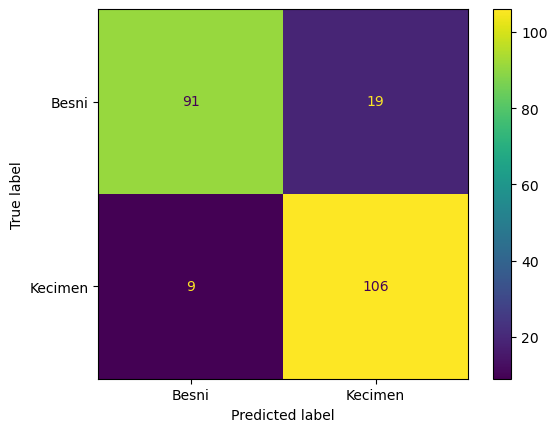

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix_data = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test).confusion_matrix
confusion_matrix_data

*Fig. 5 Confusion matrix of the LogisticRegression model*

In [ ]:
# Check target/response variable follows expected distribution
class_counts = y.value_counts()
expected_distribution = {'Kecimen': 450, 'Besni': 450}
for class_label, expected_count in expected_distribution.items():
    actual_count = class_counts.get(class_label, 0)
    if actual_count != expected_count:
        raise ValueError(f"Class '{class_label}' has {actual_count} instances; expected {expected_count}.")
        

In [46]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.8751851851851853

In [47]:
df.to_csv('data/raisin.csv')

## Summary:
From our model, we can see that many of the size-related features like `Area`, `Perimeter`, `MajorAxisLength`, and `ConvexArea` are strongly related. This means that these features are redundant, and show up more than other features. Other features like `Eccentricity` and `Extent` give us a more unique shape information of the raisin. We can also see from the summary statistics table that our dataset has a wide range of variability in size, therefore, size by itself may distinguish classes but shape metrics could help us refine classification better. With an `accuracy` score of $0.876$ and an `F1` score of $0.875$, we can see that our classifier performs well, and since both values are close to one another, we can assume that the class is balanced and not heavily skewed. With our heatmap, we can see a strong correlation between the size feature, which is likely to dominate the classifier's decision. This, however, could be a caveat. Since many of our features are highly correlated, our model may be overfitting and/or relying on redundant features. <br>
The performance of our model was aligned with what our team expected. With the high accuracy and F1 score, we can assume that features such as `Area`, `Perimeter`, `MajorAxisLength` are meaningful and make an impact when distinguishing between the raisins. Our confusion matrix, however, showed that some classes were misclassified, leading to overlapping in physical characteristics. This makes sense as it would be harder for the model to classify raisins that are visually similar to one another. <br>
With our model, quality control in agriculture and food processing could benefit tremendously as it would allow them to classify and differentiate between raisins that are in good shape, and edible and those that are not. With a high overall accuracy, we can assume that our model would help these industries could save labor, and have the classifier reliably distinguish between raisin types, reducing human error. At the same time, the misclassifications show areas where errors could happen, which could impact labeling, packaging, or pricing decisions if not addressed. <br>
The results of our analysis could lead to several future directions that could be addressed. An important question is which features contribute the most to the classification decisions, and whether other measurements, such as color, texture, or weight, could improve performance. Looking at other classification models could help us create a more reliable model, helping us yield higher accuracy or better class-specific performance. Furthermore, we have to be mindful of how well the classifier generalizes to new batches of raisins, as this could reveal potential overfitting and indicate whether the model performs reliably on unseen data.


# Citations
Olmo-Cunillera, Alexandra et al. “Is Eating Raisins Healthy?.” Nutrients vol. 12,1 54. 24 Dec. 2019, doi:10.3390/nu12010054

Wijayabahu, A.T., Waugh, S.G., Ukhanova, M. et al. Dietary raisin intake has limited effect on gut microbiota composition in adult volunteers. Nutr J 18, 14 (2019). https://doi.org/10.1186/s12937-019-0439-1

Rodrigo-Gonzalo, M.J., Recio-Rodríguez, J.I., Méndez-Sánchez, R. et al. Effect of including a dietary supplement of raisins, a food rich in polyphenols, on cognitive function in healthy older adults; a study protocol for a randomized clinical trial. BMC Geriatr 23, 182 (2023). https://doi.org/10.1186/s12877-023-03882-6

Chibuluzo, S., Pitt, T. Raisin allergy in an 8 year old patient. All Asth Clin Immun 10 (Suppl 2), A6 (2014). https://doi.org/10.1186/1710-1492-10-S2-A6

Charvet, A., Brogan Hartlieb, K., Yeh, Y. et al. A comparison of snack serving sizes to USDA guidelines in healthy weight and overweight minority preschool children enrolled in Head Start. BMC Obes 3, 36 (2016). https://doi.org/10.1186/s40608-016-0116-2

Chebil, S., Rjiba-Bahri, W., Oueslati, S. et al. Ochratoxigenic fungi and Ochratoxin A determination in dried grapes marketed in Tunisia. Ann Microbiol 70, 38 (2020). https://doi.org/10.1186/s13213-020-01584-7

